In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip3 install catboost
!pip3 install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [6]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 22.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [9]:
import unicodedata
from pathlib import Path

import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
import os

In [13]:

exp_name = 'exp00009'

outputs_path = f'/content/drive/MyDrive/Colab Notebooks/signate2023/{exp_name}/'

submission_dir = outputs_path + 'submissions/'
submission_path = submission_dir + f'submission_{exp_name}.csv'

model_dir = outputs_path + f'signate-models/'



for dir in [model_dir]:
    os.makedirs(dir, exist_ok=True)

In [2]:
INPUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/signate2023/")

In [3]:
train_df = pd.read_csv(INPUT_DIR / "train.csv")
test_df = pd.read_csv(INPUT_DIR / "test.csv")
sub_df = pd.read_csv(INPUT_DIR / "submit_sample.csv", names=["id", "price"])

In [4]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # cylinderから数値を取り出す
        X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")

        # sizeの表記揺れを修正
        X["size"] = X["size"].str.replace("ー", "-").astype(str)
        X["size"] = X["size"].str.replace("−", "-").astype(str)

        # manufacturerの表記揺れを修正
        X["manufacturer"] = X["manufacturer"].apply(
            lambda x: unicodedata.normalize("NFKC", x).lower()
        )

        # yearが3000年以降のものはおかしいので2000年に置換
        err_idx = X.query("year >= 3000").index
        X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

        # 走行距離 / 製造年
        X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

        return X


class RankTransformer(TransformerMixin, BaseEstimator):
    """keyの中でvalueが何番目のものか"""

    def __init__(self, key: str, value: str):
        self.key = key
        self.value = value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new[self.key] = X_new.groupby(self.key)[self.value].rank(method="dense")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return [self.key]


class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols


class CountTransformer(TransformerMixin, BaseEstimator):
    """CountEncoder"""

    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.ce = CountEncoder(cols=X.columns.tolist(), handle_unknown=0)
        self.ce.fit(X)
        return self

    def transform(self, X):
        return self.ce.transform(X)

    def get_feature_names_out(self, input_features=None):
        return input_features


class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [5]:
numeric_cols = ["year", "odometer", "odometer_per_year"]
categorical_cols = [
    #  'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            [
                # 'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
            ],
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.2s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.4s


In [6]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,ori__transmission,ori__drive,...,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state
17618,2012.0,92853.0,8441.181641,6.0,dodge,excellent,gas,clean,automatic,fwd,...,13131.100040,14633.535038,12296.169311,13262.602450,13911.803726,9806.656753,12192.374008,9972.890484,16949.137716,13537.107497
227,1990.0,229486.0,6954.121094,6.0,ford,good,gas,clean,automatic,4wd,...,14715.468636,10971.909137,12225.230115,13247.724494,13930.228325,18671.671152,15394.279395,13790.471227,14743.384276,14342.265360
26845,2013.0,148632.0,14863.200195,8.0,ram,excellent,diesel,clean,manual,4wd,...,24594.394954,14745.981461,24970.733552,13371.433337,12068.654852,18729.655054,15504.861210,19393.304870,14906.634062,13559.877561
27371,1996.0,190249.0,7046.259277,6.0,jeep,excellent,gas,clean,automatic,4wd,...,15163.736062,14745.981461,12282.452422,13371.433337,14025.651486,18729.655054,15504.861210,13837.067700,13551.867875,13875.105404
1124,2014.0,165339.0,18371.000000,4.0,volkswagen,good,gas,clean,automatic,fwd,...,7881.819279,10971.909137,12225.230115,13247.724494,13930.228325,9767.198243,12115.821933,11574.412180,11981.738723,11654.448509


In [7]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(100, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
# def tuning(train_feat_df, train_df, cv):
#     def objective(trial):
#         max_depth = trial.suggest_int("max_depth", 1, 10)
#         num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
#         colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
#         subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

#         params = {
#             "objective": "mape",
#             "n_estimators": 10000,
#             "learning_rate": 0.05,
#             "max_depth": max_depth,
#             "num_leaves": num_leaves,
#             "colsample_bytree": colsample_bytree,
#             "subsample": subsample,
#             "metric": "mape",
#             "importance_type": "gain",
#             "random_state": 88,
#         }

#         score, _, _ = fit_lgbm(
#             train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
#         )
#         return score

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=100)
#     print("Number of finished trials:", len(study.trials))
#     print("Best trial:", study.best_trial.params)
#     return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [15]:
n_fold = 5
lgbm_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 5,
    "num_leaves": 32,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df) for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv(f'{model_dir}/submission.csv', index=False, header=False)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold1 - 0.4482


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold2 - 0.4386


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold3 - 0.4440


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold4 - 0.4450


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold5 - 0.4401
FINISHI: Whole Score: 0.4432


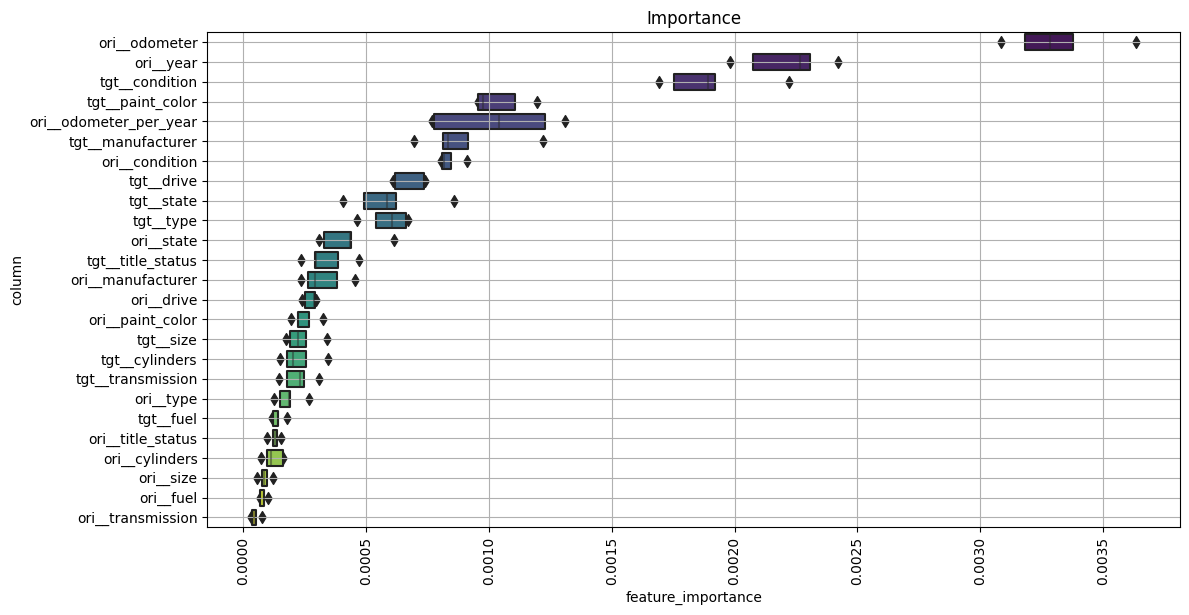

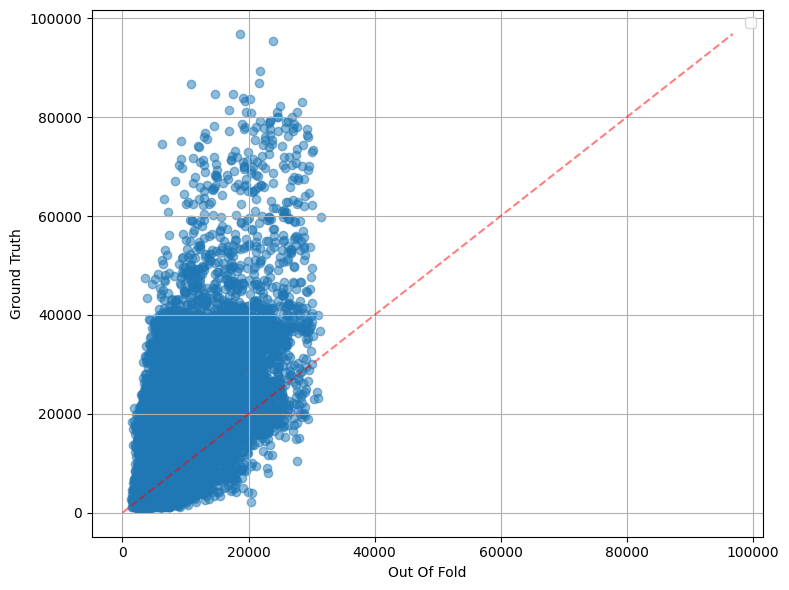

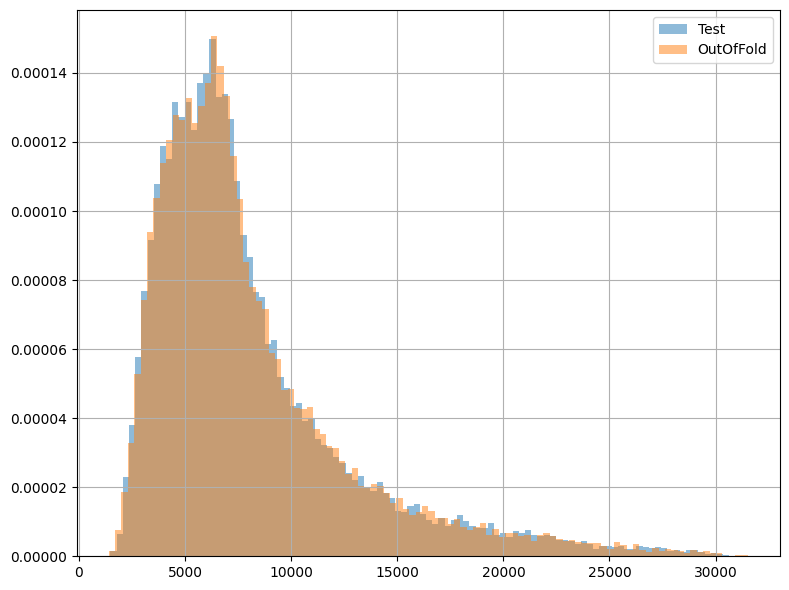

In [16]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)